In [1]:
import qsample as qs
import time
import stim
import numpy as np
import matplotlib.pyplot as plt
import time
import re
from tqdm.notebook import tqdm

# Helpers

In [2]:
def dem2matrices(dem, n_detectors):
    txt = dem.split('\n')[1:-1]
    dims = len(txt)
    errors = np.zeros(dims)
    err_locs = np.zeros((dims, n_detectors))

    for i in range(dims):
        errors[i] = re.findall('\d?\.?\d+e?\-?\d+', txt[i])[0]
        for j in re.findall('D\d', txt[i]):
            err_locs[i, int(j[1])]=1

    return errors, err_locs


def error_rate(errors, errloc, sequence):
    dep = len(sequence)
    err = len(errors)
    errors=errors.reshape(1,-1)

    result = np.stack((np.arange(2**err),) * err, axis=1)

    divide = np.stack((2**np.arange(err)[::-1],)*2**err, axis=0) 

    result=result//divide%2      # Creates binary matrix

    result=result[np.all(np.dot(result,errloc)%2==sequence, axis=1)] #find error combination that agrees with sequence
    return np.sum(np.prod(errors*result+(1-errors)*(1-result), axis=1))

In [3]:
class node:
    
    def __init__(self, circuit):
        self.circuit = circuit
        self.zero = None
        self.one = None
        
    def fail_path(self):
        fails= []
        path = []
        if self.one=='1':
            path = ['1']
            fails.append(path)
        else:
            for p in self.one.fail_path():
                p.append('1')
                fails.append(p)
        if self.zero!='0':
            for p in self.zero.fail_path():
                p.append('0')
                fails.append(p)
        return fails
    
    def fail_paths(self):
        p = []
        circs = []
        for j in self.fail_path():
            p.append(j[::-1])
            
        for j in p:
            node = self
            circ = node.circuit
            for i in j[:-1]:
                if i == '1':
                    circ+=node.one.circuit
                    node = node.one
                if i == '0':
                    circ+=node.zero.circuit
                    node = node.zero
            circs.append(circ)
            
        return p, circs

# QSample

In [4]:
eft = qs.Circuit([  {"init": {0,1,2,4,3,5,6,7}},
                    {"H": {0,1,3}},
                    {"CNOT": {(0,4)}},
                    {"CNOT": {(1,2)}},
                    {"CNOT": {(3,5)}},
                    {"CNOT": {(0,6)}},
                    {"CNOT": {(3,4)}},
                    {"CNOT": {(1,5)}},
                    {"CNOT": {(0,2)}},
                    {"CNOT": {(5,6)}},
                    {"CNOT": {(4,7)}},
                    {"CNOT": {(2,7)}},
                    {"CNOT": {(5,7)}},
                    {"measure": {7}} ])

sz_123 = qs.Circuit([   {"init": {8}},
                        {"CNOT": {(0,8)}},
                        {"CNOT": {(1,8)}},
                        {"CNOT": {(3,8)}},
                        {"CNOT": {(6,8)}},
                        {"measure": {8}}])

meas7 = qs.Circuit([ {"measure": {0,1,2,3,4,5,6}} ], noisy=False)

k1 = 0b0001111
k2 = 0b1010101
k3 = 0b0110011
k12 = k1 ^ k2
k23 = k2 ^ k3
k13 = k1 ^ k3
k123 = k12 ^ k3
stabilizerGenerators = [k1, k2, k3]
stabilizerSet = [0, k1, k2, k3, k12, k23, k13, k123]

def hamming2(x, y):
    count, z = 0, x ^ y
    while z:
        count += 1
        z &= z - 1
    return count


def logErr(out):

    c = np.array([hamming2(out, i) for i in stabilizerSet])
    d = np.flatnonzero(c <= 1)
    e = np.array([hamming2(out ^ (0b1111111), i) for i in stabilizerSet])
    f = np.flatnonzero(e <= 1)
    if len(d) != 0:
        return False
    elif len(f) != 0:
        return True
    if len(d) != 0 and len(f) != 0: 
        raise('-!-!-CANNOT BE TRUE-!-!-')

def flagged_z_look_up_table_1(z):
    s = [z]

    if s == [1]:
        return True
    else: 
        return False

functions = {"logErr": logErr, "lut": flagged_z_look_up_table_1}

steane0 = qs.Protocol(check_functions=functions, fault_tolerant=True)

steane0.add_nodes_from(['ENC', 'Z2', 'meas'], circuits=[eft, sz_123, meas7])
steane0.add_node('X_COR', circuit=qs.Circuit([{'X': {6}}], noisy=True))
steane0.add_edge('START', 'ENC', check='True')
steane0.add_edge('ENC', 'meas', check='ENC[-1]==0')
steane0.add_edge('ENC', 'Z2', check='ENC[-1]==1')
steane0.add_edge('Z2', 'X_COR', check='lut(Z2[-1])')
steane0.add_edge('Z2', 'meas', check='not lut(Z2[-1])')
steane0.add_edge('X_COR', 'meas', check='True')
steane0.add_edge('meas', 'FAIL', check='logErr(meas[-1])')

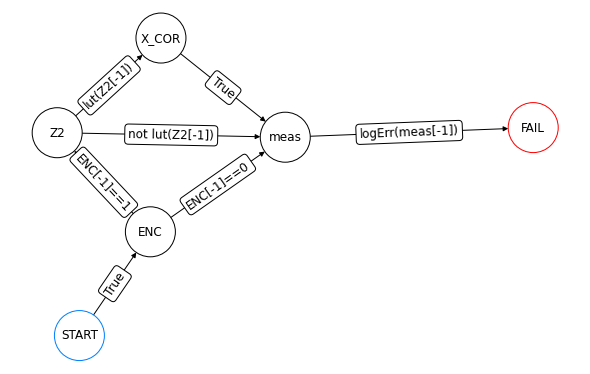

In [5]:
steane0.draw(figsize=(8,5))

In [6]:
err_model = qs.noise.E1
q = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 0.5]
err_params = {'q': q}

In [7]:
begin = time.time()
ss_sam = qs.SubsetSampler(protocol=steane0, simulator=qs.StabilizerSimulator,  p_max={'q': 0.1}, err_model=err_model, err_params=err_params, L=3)
ss_sam.run(1000)
end = time.time()
qsample_time = end-begin

p=('1.00e-01',):   0%|          | 0/1000 [00:00<?, ?it/s]

## STIM

In [8]:
ENC = """H 0 1 3\nDEPOLARIZE1({}) 0 1 3\n
                    CNOT 0 4\nDEPOLARIZE2({}) 0 4\n
                    CNOT 1 2\nDEPOLARIZE2({}) 1 2\n
                    CNOT 3 5\nDEPOLARIZE2({}) 3 5\n
                    CNOT 0 6\nDEPOLARIZE2({}) 0 6\n
                    CNOT 3 4\nDEPOLARIZE2({}) 3 4\n
                    CNOT 1 5\nDEPOLARIZE2({}) 1 5\n
                    CNOT 0 2\nDEPOLARIZE2({}) 0 2\n
                    CNOT 5 6\nDEPOLARIZE2({}) 5 6\n
                    CNOT 4 7\nDEPOLARIZE2({}) 4 7\n
                    CNOT 2 7\nDEPOLARIZE2({}) 2 7\n
                    CNOT 5 7\nDEPOLARIZE2({}) 5 7\n
                    M 7\n
                    DETECTOR rec[-1]
                      """

sz_123 = """CNOT 0 8\nDEPOLARIZE2({}) 0 8\n
            CNOT 1 8\nDEPOLARIZE2({}) 1 8\n
            CNOT 3 8\nDEPOLARIZE2({}) 3 8\n
            CNOT 6 8\nDEPOLARIZE2({}) 6 8\n
                        M 8\n
                        TICK\n
                        """


meas7 = "TICK\nM 0 1 2 3 4 5 6\n"


KZ1 = """\nCNOT 3 9\nCNOT 4 9\nCNOT 5 9\nCNOT 6 9\nM 9\n"""
KZ2 = """\nCNOT 0 10\nCNOT 2 10\nCNOT 4 10\nCNOT 6 10\nM 10\n"""
KZ3 = """\nCNOT 1 11\nCNOT 2 11\nCNOT 5 11\nCNOT 6 11\nM 11\n"""


LOG_Z = """\nCNOT 0 12\nCNOT 1 12\nCNOT 2 12\nCNOT 3 12\nCNOT 4 12\nCNOT 5 12\nCNOT 6 12\nM 12\nDETECTOR rec[-1]"""

In [9]:
kz1 = node(meas7+LOG_Z)
kz1.zero = '0'
kz1.one = '1'

enc = node(ENC)
enc.zero = kz1

sz = node(sz_123+meas7+LOG_Z)
enc.one = sz

sz.zero = '0'
sz.one = '1'

In [10]:
err_total = []
begin = time.time()
paths, circuits = enc.fail_paths()
paths = [[int(x) for x in y] for y in paths]
for i in q:
    count = 0
    for p in range(len(paths)):
        circuit = stim.Circuit(circuits[p].format(i,i,i,i,i,i,i,i,i,i,i,i,i,i,i,i,i,i,i))
        dem = circuit.detector_error_model()
        errors, errloc = dem2matrices(repr(dem),len(paths[p]))
        count+=error_rate(errors, errloc, paths[p])
    err_total.append(count**2)
end = time.time()
stim_time = end-begin

# Comparison

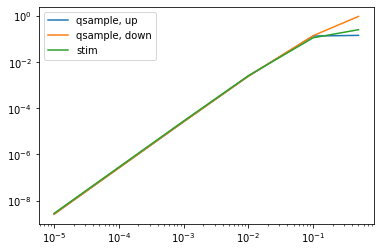

In [11]:
plt.plot(q, ss_sam.stats()[0], label = 'qsample, up')
plt.plot(q, ss_sam.stats()[2], label = 'qsample, down')
plt.plot(q, err_total, label = 'stim')
plt.xscale('log')
plt.yscale('log')
plt.legend()

In [12]:
print("QSample time: {:.3}s".format(qsample_time))
print("STIM time: {:.3}s".format(stim_time))

QSample time: 0.984s
STIM time: 0.00475s
